In [1]:
import pandas as pd
import numpy as np
import re

import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics


from scipy import sparse


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from os import system
from nltk.corpus import stopwords as stw
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name="gpu")

In [2]:
def pre_process(t1):
    # remove punctuations
    result = re.sub(r"[-,.;:@#?!_%&$`]+", ' ', t1)

    # # # remove html markup
    result = re.sub(r"(<.*>)", "", result)

    # remove non-ascii and digits
    result = re.sub("(\\W|\\d\\br)", " ", result)

    # replace multiple spaces with a single space
    result = re.sub(r"\s+", " ", result)

    return result

def pichart_categories(d_train):
    fig = plt.figure(figsize=(10, 10))
    targets, sizes = np.unique(d_train.target, return_counts=True)
    target_names = [d_train.target_names[i] for i in targets]
    patches, _, _ = plt.pie(sizes, autopct='%1.1f%%', wedgeprops={'alpha': 0.8})
    plt.legend(patches, target_names, loc=(1, 0.0))
    plt.axis('equal')
    plt.savefig("TwentyNewsGroup_pichart")
    plt.close(fig)

def eval_acc(y, y_pred):
    accuracy = np.sum(np.asarray(y_pred).reshape(-1,1) == np.asarray(y).reshape(-1,1)) / y.shape[0]
    return accuracy

In [3]:
# Load datasets and return train and test data
def load_data(name, categories, remove_headers=False):
    if name == "TwentyNewsGroups":
        dataset_train = fetch_20newsgroups(subset='train', categories = categories, shuffle=True, random_state=42,remove=('headers', 'footers','quotes'))
        dataset_test = fetch_20newsgroups(subset='test',  categories = categories, shuffle=True, random_state=42,remove=('headers', 'footers', 'quotes'))

    elif name == "Sentiment140":
        # dataset_train = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = "unicode_escape", engine = "c")
        # dataset_test = pd.read_csv('/content/new_testdata.manual.2009.06.14.csv', encoding = "unicode_escape", engine = "c")
        dataset_test = pd.read_csv('new_testdata.manual.2009.06.14.csv', names = categories)
        dataset_train = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = "latin-1", names = categories)
    else:
        print(" Incorrect database")
        dataset_train = []
        dataset_test = []

    return dataset_train, dataset_test

In [4]:
# Implementing the Multinomial Naive Bayes function


class Multinomial_NB():

    def __init__(self, alpha=1):
        self.alpha = alpha

    def fit(self, x_train_set, y_train_set):
        x_train = x_train_set
        y_train = np.array(y_train_set)
        
        # m, n = X_train.shape
        m, n = x_train.shape
        self.classes = np.unique(y_train)
        n_classes = len(self.classes)

        # init: Prior & Likelihood
        self.priors = np.zeros(n_classes)
        self.likelihoods = np.zeros((n_classes, n))

        # Get Prior and Likelihood
        for i, c in enumerate(self.classes):
            valid = np.int0(c == y_train).reshape(-1)
            valid_index = np.asarray(np.nonzero(valid)).reshape(-1)
            x_train_c = x_train[valid_index] 
            self.priors[i] = x_train_c.shape[0] / m
            self.likelihoods[i, :] = ((x_train_c.sum(axis=0)) + self.alpha) / (np.sum(x_train_c.sum(axis=0) + self.alpha))

    def predict(self, X_test):
        return [self._predict(x_test) for x_test in X_test]

    def _predict(self, x_te):
        # Calculate posterior for each class
        x_test = x_te
        posteriors = []
        for i, c in enumerate(self.classes):
            prior_c = np.log(self.priors[i])
            likelihoods_c = self.calc_likelihood(self.likelihoods[i, :], x_test)
            posteriors_c = np.sum(likelihoods_c) + prior_c
            posteriors.append(posteriors_c)
        return self.classes[np.argmax(posteriors)]

    def calc_likelihood(self, cls_likeli, x_test):
        return sparse.csr_matrix(np.log(cls_likeli)).multiply(x_test)

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.sum(y_pred == y_test) / len(y_test)

In [5]:
# Function that implements NB using the Multinomial_NB class
def Mult_NB(x_train, y_train, x_test, y_test, a=0.01):
    clf_NB = Multinomial_NB(alpha=a)
    clf_NB.fit(x_train, y_train)

    pred_test = clf_NB.predict(x_test)

    accuracy_NB_test = eval_acc(y_test, pred_test)

    pred_train = clf_NB.predict(x_train)

    accuracy_NB_train = eval_acc(y_train, pred_train)
    
    return accuracy_NB_test, accuracy_NB_train

In [6]:
# Softmax Regression using Scikit Library
def Softmax_Reg(x_train, y_train, x_test, y_test, reg_coeff, norm="l1"):
    # clf_SR = LogisticRegression(learning_rate=learning_rate, verbose=True, epsilon=epsilon)
    clf_SR = LogisticRegression(penalty = norm, fit_intercept = True, solver = 'saga', C=reg_coeff, max_iter=100000)
    clf_SR.fit(x_train, y_train)
    
    pred_test = clf_SR.predict(x_test)
    acc_test = eval_acc(y_test, pred_test)

    pred_train = clf_SR.predict(x_train)
    acc_train = eval_acc(y_train, pred_train)

    return acc_test, acc_train

In [7]:
# Compress Data using CountVectorizer to select relevant word/phrase features in doc
def features_selection(data_train, data_test, d_name, countvec=False, countvec_bigram=False, tfidfvec=False):
  if countvec:
    if d_name =="TwentyNewsGroups":
       vector_format = CountVectorizer(analyzer='word', lowercase=True, 
                                       preprocessor=pre_process, min_df = 0.01, max_df = 0.7, max_features = 20000)
       x_train = vector_format.fit_transform(data_train.data)
       y_train = data_train.target
       x_test = vector_format.transform(data_test.data)
       y_test = data_test.target
    
    else:
      vector_format = CountVectorizer(stop_words='english', analyzer='word', lowercase=True,
                                            preprocessor=pre_process, min_df = 0.005, max_df = 0.8, max_features = 10000)
      x_train = vector_format.fit_transform(data_train.iloc[:, -1].values)
      y_train = data_train.iloc[:, :1].values
      x_test = vector_format.transform(data_test.iloc[:, -1].values)
      y_test = data_test.iloc[:, :1].values

  elif countvec_bigram:
    if d_name == "TwentyNewsGroups":
      vector_format = CountVectorizer(analyzer='word', lowercase=True,
                                            preprocessor=pre_process, ngram_range=(1,2), max_features = 20000)
      x_train = vector_format.fit_transform(data_train.data)
      y_train = data_train.target
      x_test = vector_format.transform(data_test.data)
      y_test = data_test.target
    else:
      vector_format = CountVectorizer(analyzer='word', lowercase=True,
                                            preprocessor=pre_process, ngram_range=(1,2), max_features = 20000)
      x_train = vector_format.fit_transform(data_train.iloc[:, -1].values)
      y_train = data_train.iloc[:, :1].values
      x_test = vector_format.transform(data_test.iloc[:, -1].values)
      y_test = data_test.iloc[:, :1].values
  
  elif tfidfvec:
    if d_name == "TwentyNewsGroups":
      tfd_ifd = TfidfVectorizer(stop_words='english', analyzer='word', lowercase=True,
                                      preprocessor=pre_process, max_features = 20000)
      x_train = tfd_ifd.fit_transform(data_train.data)
      y_train = data_train.target
      x_test = tfd_ifd.transform(data_test.data)
      y_test = data_test.target
    # else:

  else:
      print("Feature selection type not supported")
      x_train, y_train, x_test, y_test = [], [], [], []

            
  return x_train, y_train, x_test, y_test

In [8]:
def split_training_dataset(x_train, y_train, train_percent):
    l = x_train.shape[0]
    x, y = sklearn.utils.shuffle(x_train, y_train, random_state=42)
    split = round(train_percent*l)
    if str(type(x)) == "<class 'scipy.sparse.csr.csr_matrix'>":
        indices = range(0, split)
        mask = np.zeros(x.shape[0], dtype=bool)
        mask[indices] = True
        x_t = x[mask]
        y_t = y[mask]
        x_v = x[split:]
        y_v = y[split:]

    elif str(type(x)) == "<type 'numpy.ndarray'>":
        x_t = np.concatenate((x[:split], x[split:]))
        y_t = np.concatenate((y[:split], y[split:]))
        x_v = x[split:]
        y_v = y[split]
    else:
        print(" Format not recognised")
        x_t, y_t, x_v, y_v = [], [], [], []
        
    return x_t, y_t,x_v, y_v
    

In [9]:
# K-Fold Validation on Test Dataset
def cross_validation_split(x_tr, y_tr, L, i):
    l = x_tr.shape[0]
    x, y = sklearn.utils.shuffle(x_tr, y_tr, random_state=1234)
    ratio = l/L
    start = round(ratio * i)
    end = round(ratio * (i + 1))
    if str(type(x)) == "<class 'scipy.sparse.csr.csr_matrix'>":
        indices = range(start, end)
        mask = np.ones(x.shape[0], dtype=bool)
        mask[indices] = False
        x_t = x[mask]
        y_t = y[mask]
        x_v = x[start:end]
        y_v = y[start:end]

    elif str(type(x)) == "<type 'numpy.ndarray'>":
        x_t = np.concatenate((x[:start], x[end:]))
        y_t = np.concatenate((y[:start], y[end:]))
        x_v = x[start:end]
        y_v = y[start:end]
    else:
        print(" Format not recognised")
        x_t, y_t, x_v, y_v = [], [], [], []
    return x_t, y_t,x_v, y_v


def kfoldCV(x, y, method, L,parameter=0.05 ,max_iter=100, solv='saga', reg=10, norm="l1"):
    val_acc_train, val_acc_test = [], []
    for i in range(0, L):
        x_t, y_t, x_v, y_v = cross_validation_split(x, y, L, i)
        if method == "NB":
          a_test, a_train = Mult_NB(x_t, y_t, x_v, y_v, a=parameter)
        elif method == "SR":
          a_test, a_train = Softmax_Reg(x_t, np.asarray(y_t).reshape(-1), 
                                        x_v, np.asarray(y_v).reshape(-1),
                                        parameter, norm=norm)
        val_acc_train.append(a_train)
        val_acc_test.append(a_test)
    print("Train Accuracy: ", np.mean(val_acc_train), " Test Accuracy: ", np.mean(val_acc_test))
    return np.mean(val_acc_test), np.mean(val_acc_train)

In [10]:
#MAIN BODY OF CODE STARTS HERE
## Initilization and Tuning Parameters
dataset_name = ["TwentyNewsGroups", "Sentiment140"]
categories_1 = ["comp.graphics", "comp.os.ms-windows.misc", "comp.sys.ibm.pc.hardware", "comp.sys.mac.hardware", "comp.windows.x", 
                      "rec.autos", "rec.motorcycles", "rec.sport.baseball", "rec.sport.hockey",
                      "sci.crypt", "sci.electronics", "sci.med", "sci.space",
                      "misc.forsale",
                      "talk.politics.misc", "talk.politics.guns", "talk.politics.mideast", 
                      "talk.religion.misc", "alt.atheism", "soc.religion.christian"]
categories_2 = ["polarity", "id", "date", "query", "user", "text"]
dataset_categories = [categories_1, categories_2]
p_sentiment140 = 0.03 # 3*2 = 6% of sentiment140 training sample for easy computation

method_label = ["NB", "SR"]
method = ["Naive Bayes", "Softmax Regression"]

# Hyperparaemters for both models
hyperparameter_NB = [0.001, 0.005, 0.010, 0.015, 0.020]
hyperparameter_SR = [0.01, 0.05, 0.10, 0.50, 1.00]
hyperparameter = [hyperparameter_NB, hyperparameter_SR]

best_parameter = np.zeros((2, 2)) # holds optimum parameters for both dataset and model

size = [20, 6] # total classes in TwentyNewsGroups and Sentiment140 respectively

In [ ]:
# Display pichart for TwentyNewsGroups distribution of 20 categories
pichart_categories(d_train=d_train)

In [11]:
# Choosing best norm for Softmax Regression as one of hyperparameter
norm = ["l1", "l2"]

categories = dataset_categories[1]
dataset_train, dataset_test = load_data(dataset_name[1], categories, remove_headers=True)
x_train, y_train, x_test, y_test = features_selection(dataset_train, dataset_test, dataset_name[1], countvec = True)

# select 6% of the training data
x_train_1 = x_train[:int(x_train.shape[0]*p_sentiment140), :]
x_train_2 = x_train[int(x_train.shape[0]*(1-p_sentiment140)):, :]
x_train = sparse.vstack((x_train_1[:,:], x_train_2[:,:]))

y_train_1 = y_train[:int(y_train.shape[0]*p_sentiment140)]
y_train_2 = y_train[int(y_train.shape[0]*(1-p_sentiment140)):]
y_train = np.asarray([y_train_1, y_train_2]).reshape(-1,1)

acc_list_test, acc_list_train = [], []

for norm_index in range(len(norm)):
    accuracy_test, accuracy_train = kfoldCV(x_train, y_train, method="SR", L=5, parameter=1.0, norm=norm[norm_index])
    acc_list_test.append(accuracy_test)
    acc_list_train.append(accuracy_train)

best_norm_SR = norm[np.argmax(acc_list_test)]
print("Norm that yields highest accuracy on Sentiment140 test data is %s-norm with accuracy of %.4f" % 
      (best_norm_SR, acc_list_test[np.argmax(acc_list_test)]))

Train Accuracy:  0.6656718749999999  Test Accuracy:  0.66309375
Train Accuracy:  0.6656953125  Test Accuracy:  0.66328125
Norm that yields highest accuracy on Sentiment140 test data is l2-norm with accuracy of 0.6633


Dataset:  TwentyNewsGroups
Train Accuracy:  0.8335997366783575  Test Accuracy:  0.7828627212226817
0.001  alpha completed
Train Accuracy:  0.8313093760470412  Test Accuracy:  0.783321436819012
0.005  alpha completed
Train Accuracy:  0.830164097379176  Test Accuracy:  0.7837791027229022
0.01  alpha completed
Train Accuracy:  0.8297060383665403  Test Accuracy:  0.7828616715302416
0.015  alpha completed
Train Accuracy:  0.8292479793539048  Test Accuracy:  0.7837780530304621
0.02  alpha completed


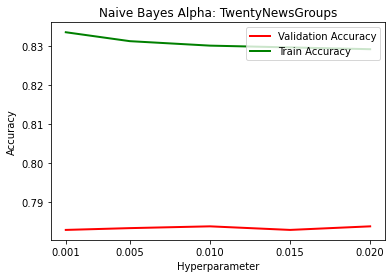

Best Hyperparameter for TwentyNewsGroups with Naive Bayes Model is: 0.010 

Train Accuracy:  0.8437926971519168  Test Accuracy:  0.7416255537127621
0.01  alpha completed
Train Accuracy:  0.8811267359984158  Test Accuracy:  0.7549094115424181
0.05  alpha completed
Train Accuracy:  0.8882270441030966  Test Accuracy:  0.7576596057355195
0.1  alpha completed
Train Accuracy:  0.8942970800541069  Test Accuracy:  0.7594934184284006
0.5  alpha completed
Train Accuracy:  0.8954423587219722  Test Accuracy:  0.7594934184284006
1.0  alpha completed


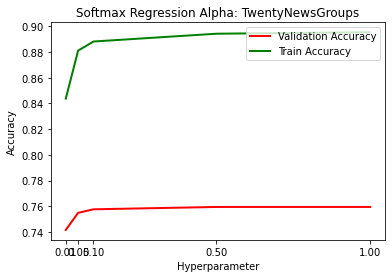

Best Hyperparameter for TwentyNewsGroups with Softmax Regression Model is: 0.500 

TwentyNewsGroups  Completed

Dataset:  Sentiment140
Train Accuracy:  0.6590442708333334  Test Accuracy:  0.6574166666666665
0.001  alpha completed
Train Accuracy:  0.6590442708333334  Test Accuracy:  0.6574166666666665
0.005  alpha completed
Train Accuracy:  0.6590338541666667  Test Accuracy:  0.6574166666666665
0.01  alpha completed
Train Accuracy:  0.6590338541666667  Test Accuracy:  0.6574166666666665
0.015  alpha completed
Train Accuracy:  0.6590338541666667  Test Accuracy:  0.6574166666666665
0.02  alpha completed


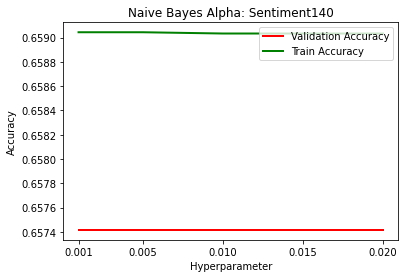

Best Hyperparameter for Sentiment140 with Naive Bayes Model is: 0.001 

Train Accuracy:  0.662671875  Test Accuracy:  0.6607916666666667
0.01  alpha completed
Train Accuracy:  0.665453125  Test Accuracy:  0.6626458333333333
0.05  alpha completed
Train Accuracy:  0.6655286458333334  Test Accuracy:  0.6631041666666666
0.1  alpha completed
Train Accuracy:  0.6656666666666666  Test Accuracy:  0.6631770833333334
0.5  alpha completed
Train Accuracy:  0.6656901041666667  Test Accuracy:  0.6632708333333334
1.0  alpha completed


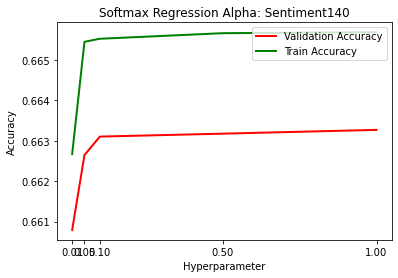

Best Hyperparameter for Sentiment140 with Softmax Regression Model is: 1.000 

Sentiment140  Completed



In [12]:
## Train vs Validation
for dataset_index in range(len(dataset_name)):
  print("Dataset: ", dataset_name[dataset_index])
  if(dataset_name[dataset_index]=="TwentyNewsGroups"):
    categories, cat = [], []
    while(not(len(cat) == size[dataset_index]//5)): # Extract four relevant classes for TwentyNewsGroups dataset
      cat = np.random.randint(0, size[dataset_index], size = size[dataset_index]//5)
      cat = np.unique(cat)
    categories = [dataset_categories[dataset_index][j] for j in cat]
  else:
    categories = [i for i in range(size[dataset_index])]
#   categories = dataset_categories[dataset_index][:]
  dataset_train, dataset_test = load_data(dataset_name[dataset_index], categories, remove_headers=True)
  x_train, y_train, x_test, y_test = features_selection(dataset_train, dataset_test, dataset_name[dataset_index], countvec = True)
  
  if(dataset_name[dataset_index] == "Sentiment140"): # select 6% of the training data
    x_train_1 = x_train[:int(x_train.shape[0]*p_sentiment140), :]
    x_train_2 = x_train[int(x_train.shape[0]*(1-p_sentiment140)):, :]
    x_train = sparse.vstack((x_train_1[:,:], x_train_2[:,:]))

    y_train_1 = y_train[:int(y_train.shape[0]*p_sentiment140)]
    y_train_2 = y_train[int(y_train.shape[0]*(1-p_sentiment140)):]
    y_train = np.asarray([y_train_1, y_train_2]).reshape(-1,1)

  # Loop through both models
  for i in range(len(method_label)):
    acc_list_test, acc_list_train = [], []
    for h in hyperparameter[i]:
      accuracy_test, accuracy_train = kfoldCV(x_train, y_train, method=method_label[i], L=5, parameter=h, norm = best_norm_SR)
      acc_list_test.append(accuracy_test)
      acc_list_train.append(accuracy_train)
      print(h, " alpha completed")
    fig = plt.figure()
    # sb = fig.add_subplot(1, 1, 1)
    plt.plot(hyperparameter[i], acc_list_test, linewidth=2,color='r', label="Validation Accuracy")
    plt.plot(hyperparameter[i], acc_list_train, linewidth = 2, color = 'g', label = "Train Accuracy")
    plt.xlabel("Hyperparameter")
    plt.ylabel("Accuracy")
    plt.xticks(hyperparameter[i])
    # sb.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    # header = "Naive Bayes" + " Alpha: " + dataset_name
    header = method[i] + " Alpha: " + dataset_name[dataset_index]
    plt.title(header)
    plt.legend(loc="upper right")
    plt.show()
    best_index = np.argmax(acc_list_test)
    best_parameter[dataset_index][i] = hyperparameter[i][best_index]
    print("Best Hyperparameter for %s with %s Model is: %.3f \n" % 
          (dataset_name[dataset_index], method[i], best_parameter[dataset_index][i]))
  print(dataset_name[dataset_index], " Completed\n")
plt.close(fig)

In [13]:
## Accuracy of Test Dataset using Best Parameters
performance_model = np.zeros((2,2))

for dataset_index in range(len(dataset_name)):
  print("Dataset: ", dataset_name[dataset_index])
  if(dataset_name[dataset_index]=="TwentyNewsGroups"):
#     categories, cat = [], []
#     while(not(len(cat) == 4)): # Extract four relevant classes for TwentyNewsGroups dataset
#       cat = np.random.randint(0, size[dataset_index], size = 4)
#       cat = np.unique(cat)
    categories = [dataset_categories[dataset_index][j] for j in cat]
  else:
    categories = [i for i in range(size[dataset_index])]
  
  dataset_train, dataset_test = load_data(dataset_name[dataset_index], categories, remove_headers=True)
  x_train, y_train, x_test, y_test = features_selection(dataset_train, dataset_test, dataset_name[dataset_index], countvec = True)

  if(dataset_name[dataset_index] == "Sentiment140"): # select 6% of the training data
    x_train_1 = x_train[:int(x_train.shape[0]*p_sentiment140), :]
    x_train_2 = x_train[int(x_train.shape[0]*(1-p_sentiment140)):, :]
    x_train = sparse.vstack((x_train_1[:,:], x_train_2[:,:]))

    y_train_1 = y_train[:int(y_train.shape[0]*p_sentiment140)]
    y_train_2 = y_train[int(y_train.shape[0]*(1-p_sentiment140)):]
    y_train = np.asarray([y_train_1, y_train_2]).reshape(-1,1)

  for i in range(len(method_label)):
    if(method_label[i] == "NB"): 
      accuracy_test, accuracy_train = Mult_NB(x_train, y_train, x_test, y_test, a=best_parameter[dataset_index][i])
    else: 
      accuracy_test, accuracy_train = Softmax_Reg(x_train, np.asarray(y_train).reshape(-1), 
                                                  x_test, np.asarray(y_test).reshape(-1), 
                                                  best_parameter[dataset_index][i], norm = best_norm_SR)
      
    print("Test Accuracy for %s Dataset using %s Model is: %.4f" % (dataset_name[dataset_index], method[i], accuracy_test))
    performance_model[dataset_index][i] = accuracy_test
  
  best_model_index = np.argmax(performance_model[dataset_index][:])
  print("Best Model for %s Dataset is %s with accuracy of %.4f" % 
        (dataset_name[dataset_index], method[best_model_index], performance_model[dataset_index][best_model_index]))
  print("")

Dataset:  TwentyNewsGroups
Test Accuracy for TwentyNewsGroups Dataset using Naive Bayes Model is: 0.7385
Test Accuracy for TwentyNewsGroups Dataset using Softmax Regression Model is: 0.7233
Best Model for TwentyNewsGroups Dataset is Naive Bayes with accuracy of 0.7385

Dataset:  Sentiment140
Test Accuracy for Sentiment140 Dataset using Naive Bayes Model is: 0.6546
Test Accuracy for Sentiment140 Dataset using Softmax Regression Model is: 0.6045
Best Model for Sentiment140 Dataset is Naive Bayes with accuracy of 0.6546



<Figure size 432x288 with 0 Axes>

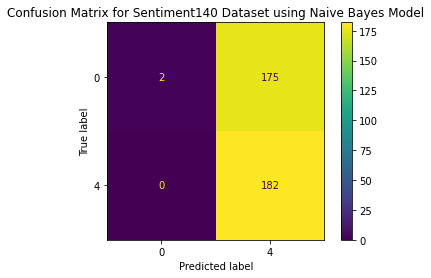

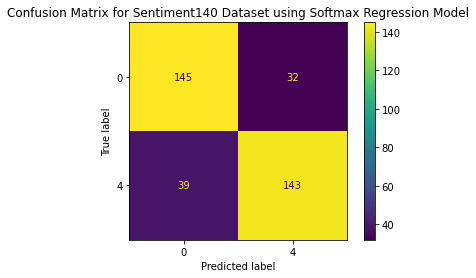

In [14]:
#Confusion Matrix
for dataset_index in range(len(dataset_name)):
  if(dataset_name[dataset_index]=="TwentyNewsGroups"):
#     categories, cat = [], []
#     while(not(len(cat) == 4)): # Extract four relevant classes for TwentyNewsGroups dataset
#       cat = np.random.randint(0, size[dataset_index], size = 4)
#       cat = np.unique(cat)
    categories = [dataset_categories[dataset_index][j] for j in cat]
  else:
    categories = [i for i in range(size[dataset_index])]
  dataset_train, dataset_test = load_data(dataset_name[dataset_index], categories, remove_headers=True)
  x_train, y_train, x_test, y_test = features_selection(dataset_train, dataset_test, dataset_name[dataset_index], countvec = True)

  if(dataset_name[dataset_index] == "Sentiment140"): # select 6% of the training data
    x_train_1 = x_train[:int(x_train.shape[0]*p_sentiment140), :]
    x_train_2 = x_train[int(x_train.shape[0]*(1-p_sentiment140)):, :]
    x_train = sparse.vstack((x_train_1[:,:], x_train_2[:,:]))

    y_train_1 = y_train[:int(y_train.shape[0]*p_sentiment140)]
    y_train_2 = y_train[int(y_train.shape[0]*(1-p_sentiment140)):]
    y_train = np.asarray([y_train_1, y_train_2]).reshape(-1,1)


  if(dataset_name[dataset_index] == "TwentyNewsGroup"):
    fig1 = plt.figure()
    for i in range(len(method)):
        classifier_NB = Multinomial_NB(alpha = best_parameter[dataset_index][i])
        classifier_NB.fit(x_train, y_train)
        plot_confusion_matrix(classifier_NB, x_test, y_test)
        plt.title("Confusion Matrix for %s Dataset using %s Model" % (dataset_name[dataset_index], method[i]))
    plt.show()
    plt.close(fig1)
  elif (dataset_name[dataset_index] == "Sentiment140"):
    fig2 = plt.figure()
    for i in range(len(method)):
        classifier_SR = LogisticRegression(penalty = best_norm_SR, fit_intercept = True, solver = 'saga', 
                                            C=best_parameter[dataset_index][i], max_iter=100000)
        classifier_SR.fit(x_test, np.asarray(y_test).reshape(-1))
        plot_confusion_matrix(classifier_SR, x_test, y_test)
        plt.title("Confusion Matrix for %s Dataset using %s Model" % (dataset_name[dataset_index], method[i]))
    plt.show()
    plt.close(fig2)

In [15]:
### Choosing Optimum Model for each dataset using combinatino of fractional training dataset
train_fraction = [0.2, 0.4, 0.6, 0.8]
new_performance_model = np.zeros((2,4,2)) # (# of dataset) x (training fraction) x (# of model)
mean_fractional_model = np.zeros((2,2)) # Mean of all fractional model --> (# of dataset) x (# of model)


for dataset_index in range(len(dataset_name)):
    print("Dataset: ", dataset_name[dataset_index])
    if(dataset_name[dataset_index]=="TwentyNewsGroups"):
#     categories, cat = [], []
#     while(not(len(cat) == 4)): # Extract four relevant classes for TwentyNewsGroups dataset
#       cat = np.random.randint(0, size[dataset_index], size = 4)
#       cat = np.unique(cat)
        categories = [dataset_categories[dataset_index][j] for j in cat]
    else:
        categories = [i for i in range(size[dataset_index])]
    dataset_train, dataset_test = load_data(dataset_name[dataset_index], categories, remove_headers=True)
    x_train, y_train, x_test, y_test = features_selection(dataset_train, dataset_test, dataset_name[dataset_index], countvec = True)

    if(dataset_name[dataset_index] == "Sentiment140"): # select 6% of the training data
        x_train_1 = x_train[:int(x_train.shape[0]*p_sentiment140), :]
        x_train_2 = x_train[int(x_train.shape[0]*(1-p_sentiment140)):, :]
        x_train = sparse.vstack((x_train_1[:,:], x_train_2[:,:]))

        y_train_1 = y_train[:int(y_train.shape[0]*p_sentiment140)]
        y_train_2 = y_train[int(y_train.shape[0]*(1-p_sentiment140)):]
        y_train = np.asarray([y_train_1, y_train_2]).reshape(-1,1)
    
    for fraction_index in range(len(train_fraction)):
        print("%0.0f%s of Training Data" % (train_fraction[fraction_index]*100, str("%")))
        half_fraction = train_fraction[fraction_index]/2
#         Get fraction of the train model using the train_fraction array
        x_train1_frac = x_train[:int(x_train.shape[0]*half_fraction), :]
        x_train2_frac = x_train[int(x_train.shape[0]*(1-half_fraction)):, :]
        x_train_frac = sparse.vstack((x_train1_frac[:,:], x_train2_frac[:,:]))

        y_train1_frac = y_train[:int(y_train.shape[0]*half_fraction)]
        y_train2_frac = y_train[int(y_train.shape[0]*(1-half_fraction)):]
        y_train_frac = np.concatenate((y_train1_frac, y_train2_frac), axis=0)
        
        for i in range(len(method_label)):
            if(method_label[i] == "NB"):
                accuracy_test, accuracy_train = Mult_NB(x_train_frac, y_train_frac, x_test, y_test, a=best_parameter[dataset_index][i])
            else: 
                accuracy_test, accuracy_train = Softmax_Reg(x_train_frac, np.asarray(y_train_frac).reshape(-1), 
                                                  x_test, np.asarray(y_test).reshape(-1), 
                                                  best_parameter[dataset_index][i], norm = best_norm_SR)
      
            print("Test Accuracy for %s Dataset using %s Model is: %.4f" % (dataset_name[dataset_index], method[i], accuracy_test))
            new_performance_model[dataset_index][fraction_index][i] = accuracy_test
        best_model_index = np.argmax(new_performance_model[dataset_index][fraction_index][:])
        print("Best Model for %s Dataset with %.0f%s of training data is %s with accuracy of %.4f" % 
            (dataset_name[dataset_index], train_fraction[fraction_index]*100, str("%"), method[best_model_index], 
             new_performance_model[dataset_index][fraction_index][best_model_index]))
    
    mean_fractional_model[dataset_index] = np.mean(new_performance_model[dataset_index], axis=0)
    best_model_index = np.argmax(mean_fractional_model[dataset_index][:])
    print("\nOptimum Model for %s Dataset is %s with mean accuracy of %.4f" %
         (dataset_name[dataset_index], method[best_model_index], mean_fractional_model[dataset_index][best_model_index]))
    print("")

Dataset:  TwentyNewsGroups
20% of Training Data
Test Accuracy for TwentyNewsGroups Dataset using Naive Bayes Model is: 0.6979
Test Accuracy for TwentyNewsGroups Dataset using Softmax Regression Model is: 0.5953
Best Model for TwentyNewsGroups Dataset with 20% of training data is Naive Bayes with accuracy of 0.6979
40% of Training Data
Test Accuracy for TwentyNewsGroups Dataset using Naive Bayes Model is: 0.7309
Test Accuracy for TwentyNewsGroups Dataset using Softmax Regression Model is: 0.6621
Best Model for TwentyNewsGroups Dataset with 40% of training data is Naive Bayes with accuracy of 0.7309
60% of Training Data
Test Accuracy for TwentyNewsGroups Dataset using Naive Bayes Model is: 0.7378
Test Accuracy for TwentyNewsGroups Dataset using Softmax Regression Model is: 0.6903
Best Model for TwentyNewsGroups Dataset with 60% of training data is Naive Bayes with accuracy of 0.7378
80% of Training Data
Test Accuracy for TwentyNewsGroups Dataset using Naive Bayes Model is: 0.7343
Test Ac